<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h2>Predicting Bee Colony Loss for US states</h2>
</div>

As observed in notebook 3 EDA, percent loss of bee colonies differs strongly across quarters and is affected by different features in different states.

Moreover, time series forecasting require the timestamps to be unique. This dataset however has the same daterange per state.

Therefore, a subset of data is taken for a given state to obtain unique timestamps and models are built per state.

**Recommended**: Run the full notebook first, results will be shown for 'Ohio'. A different state can be given as input.

At the end of the notebook, functions are available to compare outputs for different states at once for each model.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

**Runtime**: The whole notebook takes approximately 1 minute to run. This can be significantly increased if many states and/or features are chosen in the final code cell.

**ML models**: Functions to run the ML models are provided within the notebook for easy parameter adjustments.

In [47]:
import os
import sys
import warnings
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Local utilities
sys.path.append(os.path.abspath('../utils'))
from tinne_utils import (
    adf_test,
    create_quarterly_index,
    set_bee_style,
    subset_by_state
)

warnings.filterwarnings('ignore')

set_bee_style()

In [48]:
# set working directory
ITM_DIR = os.path.join(os.getcwd(), '../data/cleaned')

In [49]:
# read in data
bees = pd.read_csv(os.path.join(ITM_DIR, 'bees_clean_imputed.csv'))
bees = bees.drop('state_code', axis = 1)

In [50]:
bees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   state                      1436 non-null   object 
 1   latitude                   1436 non-null   float64
 2   longitude                  1436 non-null   float64
 3   quarter                    1436 non-null   int64  
 4   temperature_2m_mean        1436 non-null   float64
 5   temperature_2m_sum         1436 non-null   float64
 6   relative_humidity_2m_mean  1436 non-null   float64
 7   relative_humidity_2m_sum   1436 non-null   float64
 8   wind_speed_10m_max         1436 non-null   float64
 9   temperature_2m_max         1436 non-null   float64
 10  relative_humidity_2m_max   1436 non-null   float64
 11  temperature_2m_min         1436 non-null   float64
 12  relative_humidity_2m_min   1436 non-null   float64
 13  precipitation_hours_sum    1436 non-null   float

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Set State for Model Selection</h3>
</div>

A subset of data is taken for a given state to obtain unique timestamps. Forecasting models are built per state.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

In [51]:
state = 'Ohio'
state_bees = subset_by_state(bees,state)
state_bees = create_quarterly_index(state_bees)

In [52]:
state_bees.shape

(32, 51)

In [53]:
state_bees.isna().sum().sum()

0

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Sanity Check</h3>
</div>

The data should be in chronological order and the timestamps should be equidistant in time series. 

The chronological order can be achieved by sorting the dataframe by the timestamps.

 Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp is taken. 

In [54]:
state_bees = state_bees.sort_values(by='date')

state_bees['delta'] = state_bees['date'] - state_bees['date'].shift(1)

state_bees[['date', 'delta']]

state_bees['delta'].value_counts()

delta
92 days    15
91 days    10
90 days     6
Name: count, dtype: int64

Quarter lengths may vary depending on month length and leap years.

The results confirm the time interval is one quarter (90-92 days).

In [55]:
# drop delta column
state_bees = state_bees.drop('delta', axis = 1)

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Evaluation for Model Selection</h3>
</div>

Some time series models, assume that the underlying data is stationary. 

A time series is stationary if its key statistical properties do not change over time:

**Constant mean**

**Constant variance**

**Constant autocovariance (dependence between values at different lags stays the same)**

Stationarity is checked visually and statistically by the Augmented Dickey Fuller test

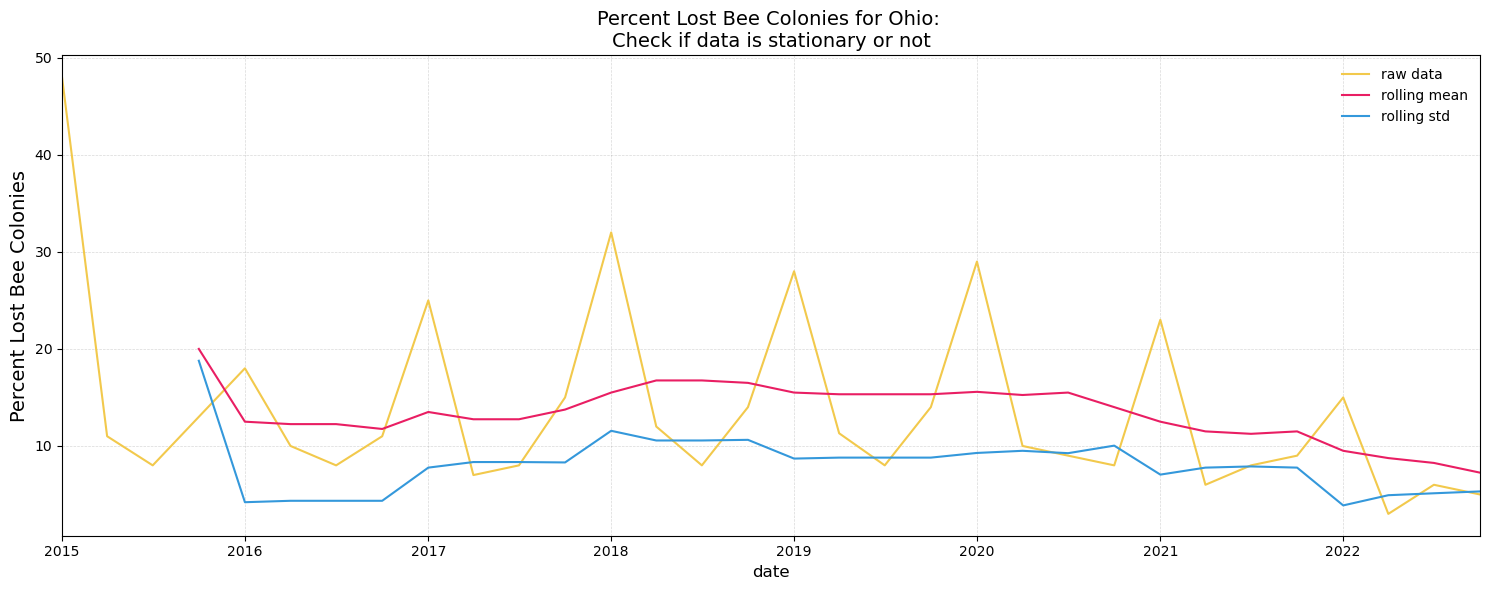

In [56]:
# Visual check of the data
rolling_window = 4

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'], ax=ax, label='raw data')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).mean(), ax=ax, label='rolling mean')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).std(), ax=ax,label='rolling std')

ax.set_title(f'Percent Lost Bee Colonies for {state}: \nCheck if data is stationary or not', fontsize=14)
ax.set_ylabel('Percent Lost Bee Colonies', fontsize=14)
ax.set_xlim([date(2015, 1, 1), date(2022, 10, 1)])

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [57]:
# Statitical test for stationarity
adf_test(state_bees['percent_lost'], state)

ADF test statistic       0.33909
p-value                 0.979069
# lags used                  4.0
# observations              27.0
critical value (1%)    -3.699608
critical value (5%)     -2.97643
critical value (10%)   -2.627601
stationary                 False
dtype: object

In [58]:
# check how many states have stationary vs non-stationary ratio
stationarity_flags = []

for state in bees['state'].unique():
    series = bees[bees['state'] == state]['percent_lost']
    result = adf_test(series, state)
    stationarity_flags.append(result['stationary'])

flags_series = pd.Series(stationarity_flags)

true_ratio = flags_series.mean()  
false_ratio = 1 - true_ratio

print(f"Stationary (True) ratio: {true_ratio:.2f}")
print(f"Non-stationary (False) ratio: {false_ratio:.2f}")

Stationary (True) ratio: 0.60
Non-stationary (False) ratio: 0.40


Looks like 60% of the states percent lost data is stationary whereas 40% is not.

Time series decomposition may provide additional information.

**ARIMA on non-stationary data** is the bigger mistake—it ignores trends and changing patterns in your series, leading to misleading results.

**SARIMAX on already stationary data** is still a problem, but mostly because it adds needless complexity and noise rather than completely breaking the model.


<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Decomposition</h3>
</div>

Time series are often a combination of trend, seasonality and noise.

- **Trend**: The overall increasing or decreasing value
- **Seasonality**: The repeating short-term cycle
- **Noise**: The random variation

Decomposition allows for for better understanding problems during analysis and forecasting

In [59]:
decomp = seasonal_decompose(state_bees['percent_lost'], period=4, model='additive', extrapolate_trend='freq')
state_bees[f"{'percent_lost'}_trend"] = decomp.trend
state_bees[f"{'percent_lost'}_seasonal"] = decomp.seasonal

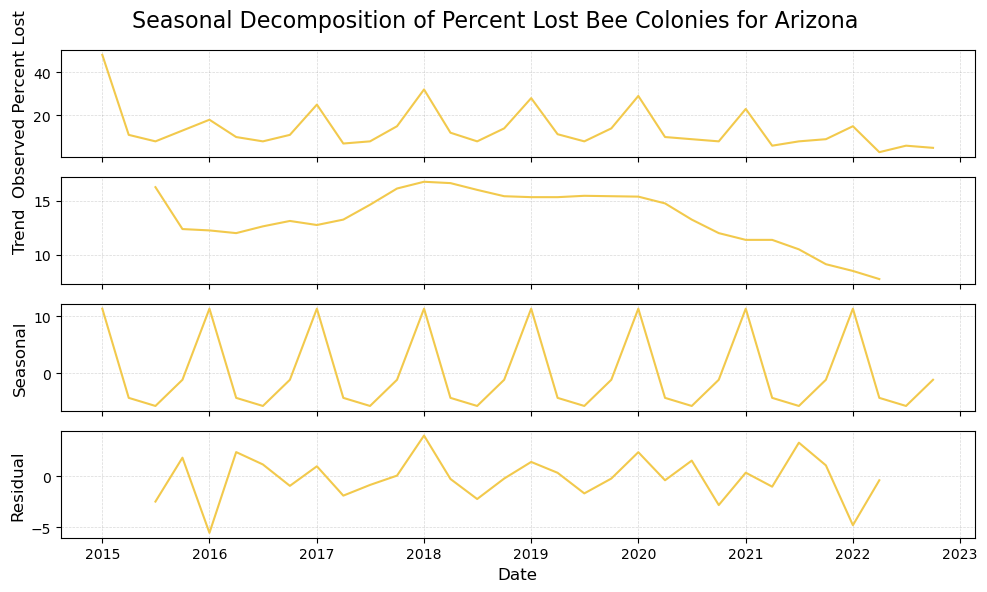

In [60]:
state_bees = state_bees.sort_values('date')
state_bees_indexed = state_bees.set_index('date')

result = seasonal_decompose(state_bees_indexed['percent_lost'], model='additive', period=4)

fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axs[0].plot(result.observed)
axs[0].set_ylabel('Observed Percent Lost')

axs[1].plot(result.trend, label='Trend')
axs[1].set_ylabel('Trend')

axs[2].plot(result.seasonal, label='Seasonal')
axs[2].set_ylabel('Seasonal')

axs[3].plot(result.resid, label='Residual')
axs[3].set_ylabel('Residual')
axs[3].set_xlabel('Date')

fig.suptitle(f'Seasonal Decomposition of Percent Lost Bee Colonies for {state}', fontsize=16)
plt.tight_layout()
plt.show()

<div
  style="
    background-color: #FCE205;
    padding: 10px 20px;      /* you can tweak horizontal padding */
    border-radius: 5px;
    color: black;
    font-weight: bold;
    height: 60px;            /* adjust as needed */
    line-height: 50px;
  "
>
  <h3 style="margin: 0;">Model Evaluation on Univariate Time series</h3>
</div>

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Univariate Time series
  </h5>
</div>


<div style="line-height:1.5">
Univariate time-series forecasting focuses on predicting future values of a single target variable using nothing but its own historical observations. 

By analyzing patterns such as trends, seasonality, and autocorrelation in past data, models like ARIMA, exponential smoothing, and modern machine-learning approaches can extrapolate into the future.
 </div>

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h8 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for univariate analysis
  </h8>
</div>

<div style="line-height:1.5">
In static forecasting our models only ever sees the “past” once and all future forecasts are extrapolations from that one fit.
 </div>

In [61]:
def compare_univariate_static(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Compute and compare static multi-step forecasts on a univariate series.

    This function fits four different models:
      - Holt–Winters Exponential Smoothing
      - SARIMAX(1,1,1)x(1,1,1,seasonal_m)
      - Random Forest on lagged features
      - XGBoost on lagged features

    It then produces forecasts for the last `n_test` periods, plots the full
    actual series alongside all model forecasts (with a train/test split marker),
    and returns a summary DataFrame of RMSE and MAE for each model.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least `date_col` and `target_col`.
    date_col : str
        Name of the column in `df` to use as the datetime index.
    target_col : str
        Name of the target variable column to forecast.
    n_test : int, default=8
        Number of periods at the end of the series reserved for testing/forecasting.
    seasonal_m : int, default=4
        Seasonal period (e.g., 4 for quarterly data).
    lags : list of int, default=[1, 4]
        List of lag orders to use as features for the RandomForest and XGBoost models.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
          - 'Model': the forecasting model name
          - 'RMSE': root mean squared error over the test set
          - 'MAE': mean absolute error over the test set
    Displays a matplotlib plot showing:
          - the full actual series in yellow
          - each model’s n_test-step forecast in dashed lines with markers
          - a vertical line marking the train/test split
    
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    series = df[target_col]

    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

    # 1) Holt–Winters
    hwes = ExponentialSmoothing(
        train, trend='add', seasonal='add', seasonal_periods=seasonal_m
    ).fit()
    hwes_preds = pd.Series(hwes.forecast(n_test), index=test.index)

    # 2) SARIMAX
    sarimax = SARIMAX(
        train,
        order=(1,1,1),
        seasonal_order=(1,1,1,seasonal_m),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    sarimax_preds = pd.Series(
        sarimax.forecast(steps=n_test),
        index=test.index
    )

    # 3) lag features
    df_lag = pd.DataFrame({target_col: series})
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag[target_col].shift(lag)
    df_lag.dropna(inplace=True)

    ml_train = df_lag.iloc[:-n_test]
    ml_test  = df_lag.iloc[-n_test:]
    X_train, y_train = ml_train[[f'lag_{lag}' for lag in lags]], ml_train[target_col]
    X_test,  y_test  = ml_test [[f'lag_{lag}' for lag in lags]], ml_test[target_col]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = pd.Series(rf.predict(X_test), index=y_test.index)

    xgb = XGBRegressor(
        n_estimators=100, random_state=42,
        use_label_encoder=False, eval_metric='rmse'
    )
    xgb.fit(X_train, y_train)
    xgb_preds = pd.Series(xgb.predict(X_test), index=y_test.index)

    # metrics
    def compute_metrics(y_true, y_pred):
        mask = (~y_true.isna()) & (~y_pred.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            mean_absolute_error(y_true[mask], y_pred[mask])
        )

    models     = ['HWES', 'SARIMAX', 'RF (lags)', 'XGB (lags)']
    predictions = [hwes_preds, sarimax_preds, rf_preds, xgb_preds]

    metrics = pd.DataFrame([
        (m, *compute_metrics(test, p))
        for m,p in zip(models, predictions)
    ], columns=['Model','RMSE','MAE'])

    # **Round** to two decimal places
    metrics[['RMSE','MAE']] = metrics[['RMSE','MAE']].round(2)

    # plot
    actual_full = series
    df_fore = pd.DataFrame({
        'HWES':       hwes_preds,
        'SARIMAX':    sarimax_preds,
        'RF (lags)':  rf_preds,
        'XGB (lags)': xgb_preds
    })
    df_plot = pd.concat([actual_full.rename('Actual'), df_fore], axis=1)

    fig, ax = plt.subplots(figsize=(12,6))
    df_plot['Actual'].plot(ax=ax, lw=2, label='Actual', color='gold')
    df_plot[['HWES','SARIMAX','RF (lags)','XGB (lags)']].plot(
        ax=ax, linestyle='--', marker='o', alpha=0.8
    )
    split_date = train.index[-1]
    ax.axvline(split_date, linestyle=':', label='Train/Test split')
    ax.set_title(f'Full Actual Series + {n_test}-Step Forecasts by Model')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics

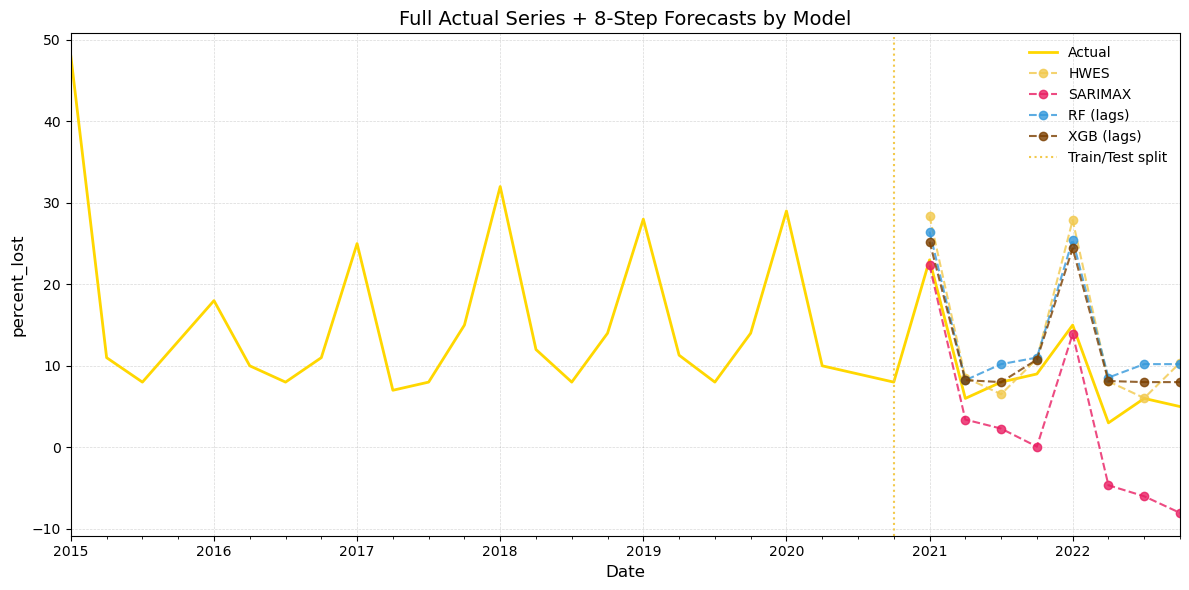

,Model,RMSE,MAE
0,HWES,5.72,4.33
1,SARIMAX,7.85,6.46
2,RF (lags),5.14,4.42
3,XGB (lags),4.20,3.22


In [62]:
compare_univariate_static(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk forward method univariate analysis
  </h7>
</div>

<div style="line-height:1.5">
Walk-forward (rolling) forecasting continuously retrains or updates the models as each new observation becomes available, ensuring that the predictions always leverage the most recent data and adapt to evolving patterns.

 </div>

In [63]:
def evaluate_and_plot_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Perform one-step walk-forward forecasting with multiple models and plot cumulative errors.

    This routine fits four models in a rolling, one-step-ahead fashion on a univariate time series:
      1. Holt–Winters Exponential Smoothing
      2. SARIMAX(1,1,1)x(1,1,1,seasonal_m)
      3. Random Forest using specified lag features
      4. XGBoost using specified lag features

    For each step in the final `n_test` observations, it:
      - Re-fits the model on all available history
      - Forecasts the next point
      - Appends the true value to history

    After forecasting, it computes overall RMSE and MAE for each model, then
    plots the cumulative RMSE and MAE by quarter.

    Parameters
    ----------
    df : pd.DataFrame
        Input data containing at least a date column and a target column.
    date_col : str
        Name of the datetime column to use as the index.
    target_col : str
        Name of the series to forecast.
    n_test : int, default=8
        Number of last observations to reserve for walk-forward testing.
    seasonal_m : int, default=4
        Seasonal period (e.g. 4 for quarterly data).
    lags : list[int], default=[1, 4]
        Lag orders to generate features for the RF and XGB models.

    Returns
    -------
    pd.DataFrame
        A table of overall forecast accuracy:
          - Model: model name
          - RMSE: root mean squared error over all test steps
          - MAE: mean absolute error over all test steps
    Displays two side-by-side matplotlib plots:
        • Cumulative RMSE by quarter
        • Cumulative MAE by quarter

    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    series = df.set_index(date_col)[target_col].sort_index()

    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

        # 1) Generic walk-forward
    def walk_forward(model_builder, forecast_fn):
        history = train.copy()
        preds   = []
        for t in range(n_test):
            m  = model_builder(history)
            fc = forecast_fn(m, history)
            preds.append(fc)
            history.loc[test.index[t]] = test.iloc[t]
        return np.array(preds)

    # 2) Model builders & fns

    # Holt–Winters
    def build_hwes(y):
        return ExponentialSmoothing(
            y, trend='add', seasonal='add',
            seasonal_periods=seasonal_m
        ).fit()
    def f_hwes(m, h): 
        return m.forecast(1).iloc[0]

    # Fixed SARIMAX
    def build_sarimax(y):
        return SARIMAX(
            y,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal_m),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
    def f_sarimax(m, h):
        return m.forecast(steps=1).iloc[0]

    # Random Forest on lags
    def build_rf(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        return rf
    def f_rf(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    # XGBoost on lags
    def build_xgb(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        xgb = XGBRegressor(
            n_estimators=100, random_state=42,
            use_label_encoder=False, eval_metric='rmse'
        )
        xgb.fit(X, y)
        return xgb
    def f_xgb(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    # 3) Run forecasts
    preds_hwes    = walk_forward(build_hwes,    f_hwes)
    preds_sarimax = walk_forward(build_sarimax, f_sarimax)
    preds_rf      = walk_forward(build_rf,      f_rf)
    preds_xgb     = walk_forward(build_xgb,     f_xgb)

    # 4) Overall metrics
    metrics = pd.DataFrame({
        'Model': ['HWES', 'SARIMAX', 'RF (lags)', 'XGB (lags)'],
        'RMSE': [
            np.sqrt(mean_squared_error(test, preds_hwes)),
            np.sqrt(mean_squared_error(test, preds_sarimax)),
            np.sqrt(mean_squared_error(test, preds_rf)),
            np.sqrt(mean_squared_error(test, preds_xgb))
        ],
        'MAE': [
            mean_absolute_error(test, preds_hwes),
            mean_absolute_error(test, preds_sarimax),
            mean_absolute_error(test, preds_rf),
            mean_absolute_error(test, preds_xgb)
        ]
    })

    # **Round** RMSE & MAE to two decimals
    metrics[['RMSE','MAE']] = metrics[['RMSE','MAE']].round(2)

    # 5) Build cumulative error DataFrames (indexed by quarter dates)
    idx = test.index
    quarters = [f"{d.year}Q{d.quarter}" for d in idx]

    cum_rmse = pd.DataFrame({
        'HWES':      [np.sqrt(mean_squared_error(test.values[:k], preds_hwes[:k])) for k in range(1, n_test+1)],
        'SARIMAX':   [np.sqrt(mean_squared_error(test.values[:k], preds_sarimax[:k])) for k in range(1, n_test+1)],
        'RF (lags)': [np.sqrt(mean_squared_error(test.values[:k], preds_rf[:k])) for k in range(1, n_test+1)],
        'XGB (lags)':[np.sqrt(mean_squared_error(test.values[:k], preds_xgb[:k])) for k in range(1, n_test+1)]
    }, index=idx)

    cum_mae = pd.DataFrame({
        'HWES':      [mean_absolute_error(test.values[:k], preds_hwes[:k]) for k in range(1, n_test+1)],
        'SARIMAX':   [mean_absolute_error(test.values[:k], preds_sarimax[:k]) for k in range(1, n_test+1)],
        'RF (lags)': [mean_absolute_error(test.values[:k], preds_rf[:k]) for k in range(1, n_test+1)],
        'XGB (lags)':[mean_absolute_error(test.values[:k], preds_xgb[:k]) for k in range(1, n_test+1)]
    }, index=idx)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    cum_rmse.plot(ax=ax1, marker='o')
    ax1.set_title('Cumulative RMSE by Predicted Quarter')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RMSE')
    ax1.grid(True)
    ax1.set_xticks(idx)
    ax1.set_xticklabels(quarters, rotation=90, ha='center')

    cum_mae.plot(ax=ax2, marker='o')
    ax2.set_title('Cumulative MAE by Predicted Quarter')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MAE')
    ax2.grid(True)
    ax2.set_xticks(idx)
    ax2.set_xticklabels(quarters, rotation=90, ha='center')

    plt.tight_layout()
    plt.show()

    return metrics


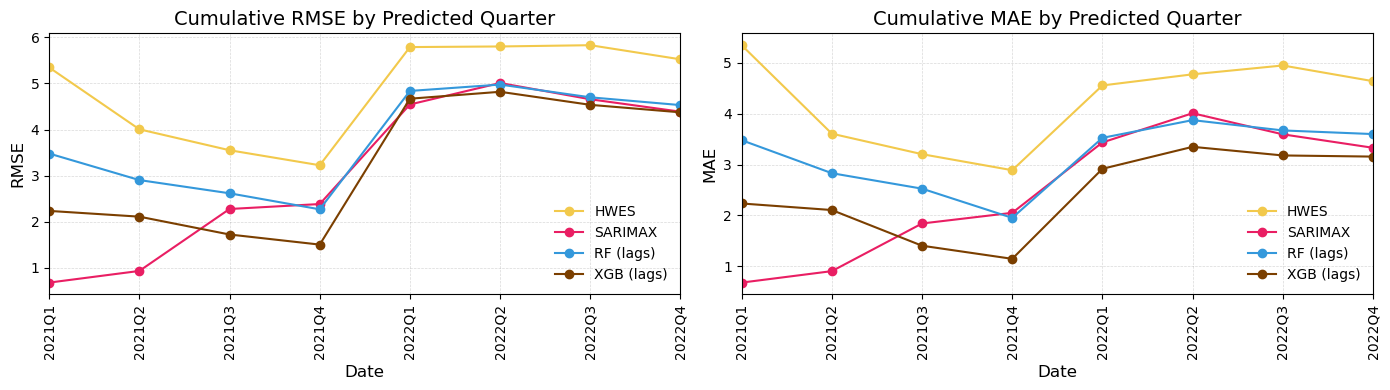

        Model  RMSE   MAE
0        HWES  5.52  4.64
1     SARIMAX  4.39  3.33
2   RF (lags)  4.53  3.60
3  XGB (lags)  4.37  3.16


In [64]:
metrics = evaluate_and_plot_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1,4]
)
print(metrics)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Multivariate Time series
  </h5>
</div>

Multivariate forecasting lets us incorporate additional features (exogenous features, e.g. weather, diseases) into models. However, when we roll our model forward to make predictions, we typically no longer have “future” values of those features. To address this, we derive lagged versions of every input (target and exogenous) from the historical data (e.g. t-1, t-4, etc.). We will train Random Forest and XGBoost models on those lagged features and when forecasting, we again supply just those same lagged values. This ensures our predictions rely solely on information that would actually have been available at forecast time.

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis
  </h7>
</div>

In [65]:
# available columns for multivariate analysis
state_bees.columns

Index(['state', 'latitude', 'longitude', 'quarter', 'temperature_2m_mean',
       'temperature_2m_sum', 'relative_humidity_2m_mean',
       'relative_humidity_2m_sum', 'wind_speed_10m_max', 'temperature_2m_max',
       'relative_humidity_2m_max', 'temperature_2m_min',
       'relative_humidity_2m_min', 'precipitation_hours_sum',
       'moderate_drizzle_sum', 'moderate_rain_sum', 'light_rain_sum',
       'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum', 'clear_sky_sum',
       'light_drizzle_sum', 'mainly_clear_sum', 'heavy_drizzle_sum',
       'light_snow_sum', 'heavy_snow_sum', 'moderate_snow_sum', 'year',
       'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean', 'D4_mean', 'D0_max',
       'D1_max', 'D2_max', 'D3_max', 'D4_max', 'num_colonies', 'max_colonies',
       'lost_colonies', 'percent_lost', 'added_colonies', 'renovated_colonies',
       'percent_renovated', 'varroa_mites', 'other_pests_and_parasites',
       'diseases', 'pesticides', 'other_or_unknown', 'date',
       'percen

In [66]:

def compare_multivariate_models(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Fit and compare multivariate forecasting models on one target series.

    Models:
      - SARIMAX with exogenous covariates
      - RandomForest on lagged features
      - XGBoost on lagged features

    Holds out final n_test points to compute RMSE & MAE (rounded to 2 decimals).
    Plots actual vs forecasts (static), then shows top-10 feature importances for RF & XGB.

    Returns
    -------
    pd.DataFrame
        Columns: Model, RMSE, MAE
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    y_full   = df[target_col]
    exog     = df[exog_cols]
    train_y  = y_full.iloc[:-n_test]
    test_y   = y_full.iloc[-n_test:]
    train_ex = exog.iloc[:-n_test]
    test_ex  = exog.iloc[-n_test:]

    # 1) SARIMAX
    sar = SARIMAX(
        train_y,
        exog=train_ex,
        order=(1,1,1),
        seasonal_order=(1,1,1,seasonal_m),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    sar_preds = pd.Series(
        sar.predict(start=test_y.index[0],
                    end=test_y.index[-1],
                    exog=test_ex),
        index=test_y.index
    )

    # 2) Random Forest with lag features
    df_ml = pd.concat([y_full.rename(target_col), exog], axis=1)
    for col in df_ml.columns:
        for lag in lags:
            df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
    df_ml.dropna(inplace=True)

    ml_train = df_ml.iloc[:-n_test]
    ml_test  = df_ml.iloc[-n_test:]
    X_tr, y_tr = ml_train.drop(columns=[target_col]), ml_train[target_col]
    X_te, y_te = ml_test.drop(columns=[target_col]), ml_test[target_col]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_tr, y_tr)
    rf_preds = pd.Series(rf.predict(X_te), index=y_te.index)

    # 3) XGBoost with lag features
    xgb = XGBRegressor(
        n_estimators=100, random_state=42,
        use_label_encoder=False, eval_metric='rmse'
    )
    xgb.fit(X_tr, y_tr)
    xgb_preds = pd.Series(xgb.predict(X_te), index=y_te.index)

    # Compute metrics
    def compute_metrics(y_t, y_p):
        mask = (~y_t.isna()) & (~y_p.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_t[mask], y_p[mask])),
            mean_absolute_error(y_t[mask], y_p[mask])
        )

    metrics = pd.DataFrame([
        ('SARIMAX',    *compute_metrics(test_y, sar_preds)),
        ('RF (lags)',  *compute_metrics(y_te, rf_preds)),
        ('XGB (lags)', *compute_metrics(y_te, xgb_preds))
    ], columns=['Model', 'RMSE', 'MAE'])

    # Round RMSE & MAE
    metrics[['RMSE','MAE']] = metrics[['RMSE','MAE']].round(2)

    # Plot actual vs. forecasts (using your custom bee style)
    df_fore = pd.DataFrame({
        'SARIMAX':    sar_preds,
        'RF (lags)':  rf_preds,
        'XGB (lags)': xgb_preds
    })
    df_plot = pd.concat([y_full.rename('Actual'), df_fore], axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Actual
    df_plot['Actual'].plot(ax=ax, marker='o', linestyle='-', label='Actual')
    
    # Plot forecasts in order
    for col in ['SARIMAX','RF (lags)','XGB (lags)']:
        df_plot[col].plot(ax=ax, marker='o', linestyle='--', alpha=0.8, label=col)
    
    # Vertical line at split
    split_date = train_y.index[-1]
    ax.axvline(split_date, linestyle=':', label='Train/Test split')
    
    # Titles & labels
    ax.set_title('Multivariate Static Forecasts vs. Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    
    # Quarterly tick labels
    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance on full training data
    rf_final  = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_tr, y_tr)
    xgb_final = XGBRegressor(
        n_estimators=100, random_state=42,
        use_label_encoder=False, eval_metric='rmse'
    ).fit(X_tr, y_tr)
    
    imp = pd.DataFrame({
        'RF':  rf_final.feature_importances_,
        'XGB': xgb_final.feature_importances_
    }, index=X_tr.columns).sort_values('RF', ascending=False).head(10)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    imp.plot.bar(ax=ax)
    ax.set_title('Top-10 Feature Importances (RF vs XGB)')
    ax.set_ylabel('Importance')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

    return metrics

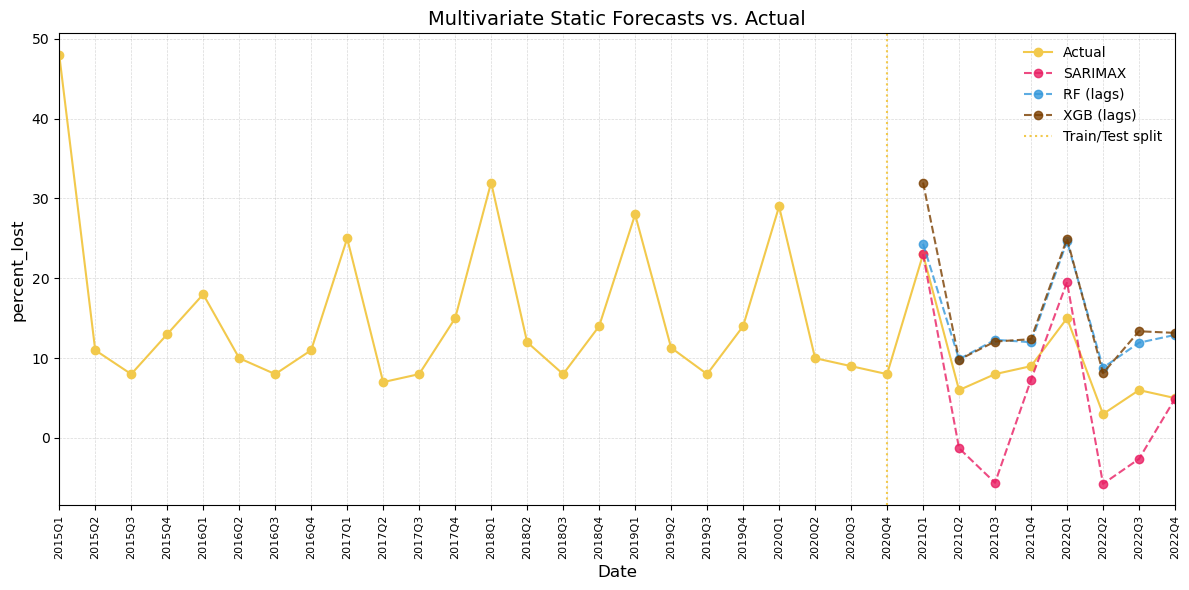

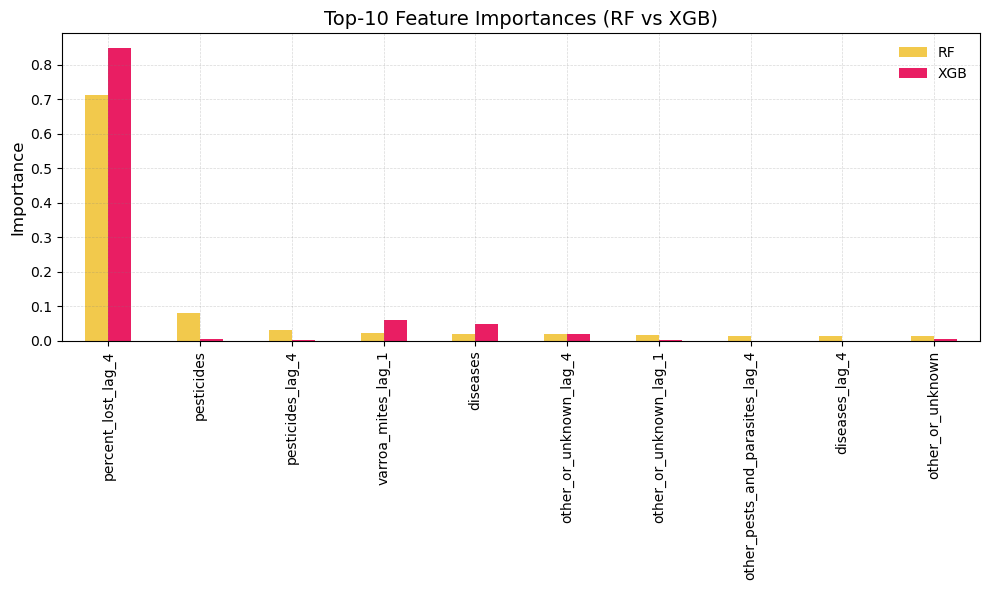

,Model,RMSE,MAE
0,SARIMAX,7.18,5.57
1,RF (lags),5.79,5.22
2,XGB (lags),6.80,6.36


In [67]:
compare_multivariate_models(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ],
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis with variable training windows
  </h7>
</div>

In [68]:
def compare_multivariate_static_windows(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    windows: list[int],
    forecast_horizon: int = 4,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Compare static multi-step forecasts across different training-window sizes.

    Models:
      - SARIMAX with exogenous regressors
      - RandomForest on lagged features
      - XGBoost on lagged features

    Returns a DataFrame (train_quarters, Model, RMSE, MAE), with RMSE/MAE rounded to 2 decimals,
    plots RMSE vs. window size, and shows top‐10 feature importances.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    series = df[target_col]
    exog   = df[exog_cols]
    N      = len(series)

    # Precompute lagged features once, rename target to target_col
    df_lag = pd.concat([series.rename(target_col), exog], axis=1)
    for col in df_lag.columns:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag[col].shift(lag)
    df_lag.dropna(inplace=True)

    results = []
    for w in windows:
        if w + forecast_horizon > N:
            continue

        start = N - forecast_horizon - w
        train_y = series.iloc[start : start + w]
        test_y  = series.iloc[N - forecast_horizon : N]
        train_ex = exog.iloc[start : start + w]
        test_ex  = exog.iloc[N - forecast_horizon : N]
        idx      = test_y.index

        # SARIMAX
        try:
            m_sar = SARIMAX(
                train_y, exog=train_ex,
                order=(1,1,1),
                seasonal_order=(1,1,1,seasonal_m),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            sar_preds = m_sar.get_forecast(
                steps=forecast_horizon, exog=test_ex
            ).predicted_mean
        except:
            sar_preds = pd.Series([np.nan]*forecast_horizon, index=idx)
        rmse_sar = np.sqrt(mean_squared_error(test_y, sar_preds))
        mae_sar  = mean_absolute_error(test_y, sar_preds)
        results.append((w, 'SARIMAX', rmse_sar, mae_sar))

        # RF on lags
        train_ml = df_lag.loc[train_y.index.intersection(df_lag.index)]
        test_ml  = df_lag.loc[test_y.index.intersection(df_lag.index)]
        if train_ml.empty or test_ml.empty:
            rmse_rf, mae_rf = np.nan, np.nan
        else:
            X_tr, y_tr = train_ml.drop(columns=[target_col]), train_ml[target_col]
            X_te, y_te = test_ml.drop(columns=[target_col]), test_ml[target_col]
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_tr, y_tr)
            rf_preds = pd.Series(rf.predict(X_te), index=test_ml.index)
            rmse_rf = np.sqrt(mean_squared_error(y_te, rf_preds))
            mae_rf  = mean_absolute_error(y_te, rf_preds)
        results.append((w, 'RF', rmse_rf, mae_rf))

        # XGB on lags
        if train_ml.empty or test_ml.empty:
            rmse_xgb, mae_xgb = np.nan, np.nan
        else:
            xgb = XGBRegressor(
                n_estimators=100, random_state=42,
                use_label_encoder=False, eval_metric='rmse'
            )
            xgb.fit(X_tr, y_tr)
            xgb_preds = pd.Series(xgb.predict(X_te), index=test_ml.index)
            rmse_xgb = np.sqrt(mean_squared_error(y_te, xgb_preds))
            mae_xgb  = mean_absolute_error(y_te, xgb_preds)
        results.append((w, 'XGB', rmse_xgb, mae_xgb))

    # Build metrics DataFrame
    metrics_df = pd.DataFrame(results, columns=['train_quarters','Model','RMSE','MAE'])
    # Round RMSE & MAE to two decimals
    metrics_df[['RMSE','MAE']] = metrics_df[['RMSE','MAE']].round(2)

    # --- Plot RMSE vs. window size (using your bee style) ---
    pivot_rmse = metrics_df.pivot(index='train_quarters', columns='Model', values='RMSE')
    
    fig, ax = plt.subplots(figsize=(8, 5))
    pivot_rmse.plot(marker='o', ax=ax)
    ax.set_title(f'RMSE vs Training-Window Size (h={forecast_horizon})')
    ax.set_xlabel('Training Window (quarters)')
    ax.set_ylabel('RMSE')
    ax.grid(True)  # grid style comes from your rcParams
    plt.tight_layout()
    plt.show()
    
    # --- Feature importance (top 10) on largest valid window ---
    max_w = max(w for w in windows if w + forecast_horizon <= N)
    start = N - forecast_horizon - max_w
    train_full = series.iloc[start : start + max_w]
    exog_full  = exog.iloc[start : start + max_w]
    
    df_full_ml = pd.concat([train_full.rename(target_col), exog_full], axis=1)
    for col in df_full_ml.columns:
        for lag in lags:
            df_full_ml[f'{col}_lag_{lag}'] = df_full_ml[col].shift(lag)
    df_full_ml.dropna(inplace=True)
    
    X_full, y_full = df_full_ml.drop(columns=[target_col]), df_full_ml[target_col]
    
    rf_final  = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_full, y_full)
    xgb_final = XGBRegressor(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='rmse'
    ).fit(X_full, y_full)
    
    imp = pd.DataFrame({
        'RF':  rf_final.feature_importances_,
        'XGB': xgb_final.feature_importances_
    }, index=X_full.columns).sort_values('RF', ascending=False).head(10)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    imp.plot.bar(ax=ax)
    ax.set_title(f'Top-10 Feature Importances (trained on last {max_w} quarters)')
    ax.set_ylabel('Importance')
    ax.grid(axis='y', linestyle='--')  # horizontal grid lines
    plt.tight_layout()
    plt.show()

    return metrics_df

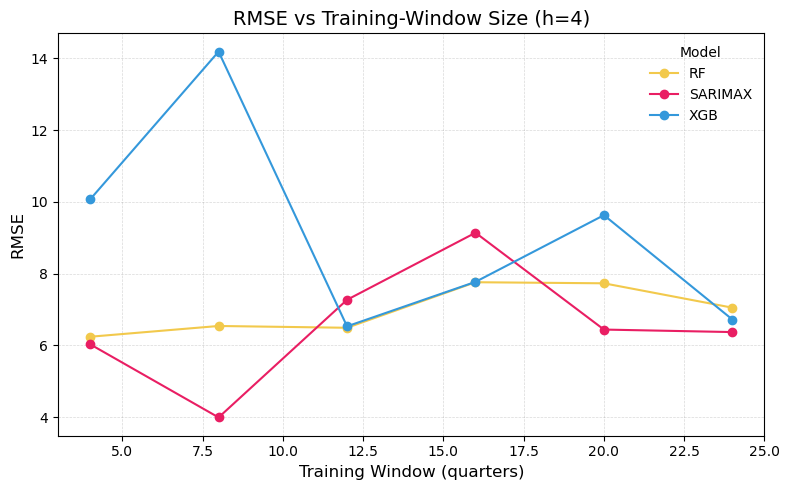

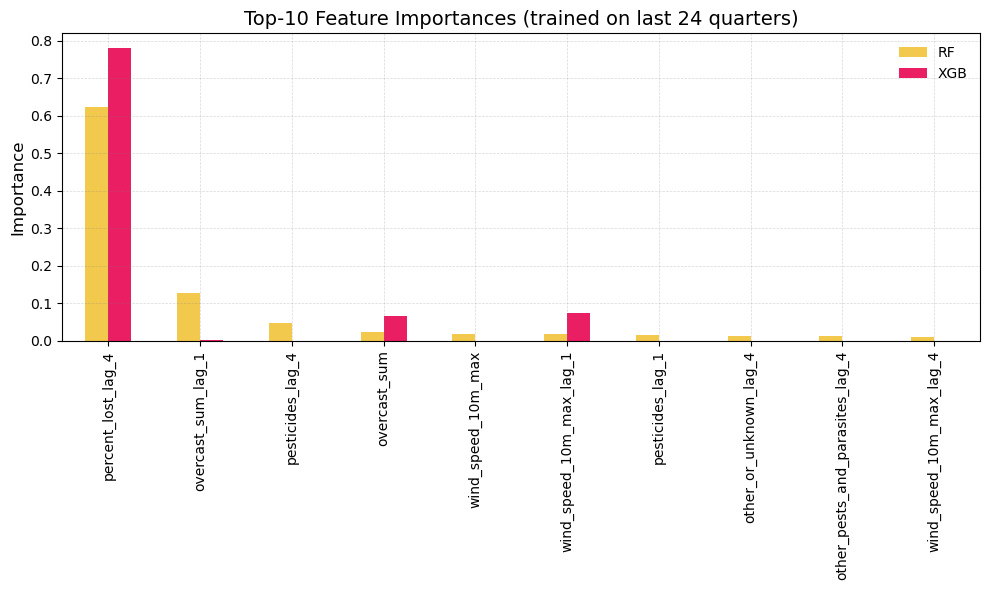

,train_quarters,Model,RMSE,MAE
0,4,SARIMAX,6.03,5.58
1,4,RF,6.24,5.76
2,4,XGB,10.07,8.00
3,8,SARIMAX,3.99,3.28
4,8,RF,6.54,5.61
5,8,XGB,14.19,11.50
6,12,SARIMAX,7.27,5.08
7,12,RF,6.49,6.14
8,12,XGB,6.53,5.94
9,16,SARIMAX,9.14,6.28


In [69]:
compare_multivariate_static_windows(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=['varroa_mites','other_pests_and_parasites','diseases','pesticides','other_or_unknown',
        'overcast_sum','clear_sky_sum','longitude','partly_cloudy_sum','relative_humidity_2m_max',
        'mainly_clear_sum','wind_speed_10m_max','D4_mean'
        ],
    windows=[4,8,12,16,20,24],
    forecast_horizon=4,
    seasonal_m=4,
    lags=[1,4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk-forward method for multivariate analysis
  </h7>
</div>

In [70]:
def compare_multivariate_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Perform one-step walk-forward forecasting with multiple multivariate models:
      - SARIMAX with exogenous regressors
      - RandomForest on lagged features
      - XGBoost on lagged features

    For each of the last n_test periods, the function
    1) fits SARIMAX(1,1,1)x(1,1,1,seasonal_m) with exog,
    2) fits RF and XGB on lagged target+exog,
    3) forecasts one step ahead,
    4) appends the true value to history.

    Displays:
      - Actual vs. forecasts plot
      - Cumulative RMSE & MAE by quarter
      - Top-10 feature importance bar chart for RF and XGB

    Returns
    -------
    metrics : DataFrame
        Model, RMSE, MAE (rounded to 2 decimals) for each model.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    train_df = df.iloc[:-n_test]
    test_df  = df.iloc[-n_test:]
    history  = train_df.copy()
    idx_test = test_df.index

    preds = {'SARIMAX': [], 'RF (lags)': [], 'XGB (lags)': []}

    # Walk-forward loop
    for t in range(n_test):
        # SARIMAX
        y_hist, ex_hist = history[target_col], history[exog_cols]
        try:
            m_sar = SARIMAX(
                y_hist,
                exog=ex_hist,
                order=(1,1,1),
                seasonal_order=(1,1,1,seasonal_m),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            ex_next = test_df[exog_cols].iloc[[t]]
            sar_fc = m_sar.get_forecast(steps=1, exog=ex_next).predicted_mean
            preds['SARIMAX'].append(sar_fc.iloc[0])
        except:
            preds['SARIMAX'].append(np.nan)

        # Build lagged features for ML
        df_ml = history[[target_col] + exog_cols].copy()
        for col in [target_col] + exog_cols:
            for lag in lags:
                df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
        df_ml.dropna(inplace=True)
        X_ml, y_ml = df_ml.drop(columns=[target_col]), df_ml[target_col]

        # Next-step feature row
        feat = {col: test_df[col].iloc[t] for col in exog_cols}
        for col in [target_col] + exog_cols:
            for lag in lags:
                feat[f'{col}_lag_{lag}'] = history[col].iloc[-lag]
        feat_df = pd.DataFrame([feat])

        # RandomForest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_ml, y_ml)
        preds['RF (lags)'].append(rf.predict(feat_df)[0])

        # XGBoost
        xgb = XGBRegressor(n_estimators=100, random_state=42,
                           use_label_encoder=False, eval_metric='rmse')
        xgb.fit(X_ml, y_ml)
        preds['XGB (lags)'].append(xgb.predict(feat_df)[0])

        # reveal next actual
        history = pd.concat([history, test_df.iloc[[t]]])

    # Build prediction series
    s_true = test_df[target_col]
    s_pred = {
        name: pd.Series(vals, index=idx_test, name=name)
        for name, vals in preds.items()
    }

    # Compute metrics
    def score(y_t, y_p):
        mask = (~y_t.isna()) & (~y_p.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_t[mask], y_p[mask])),
            mean_absolute_error(y_t[mask], y_p[mask])
        )

    metrics = pd.DataFrame([
        (name, *score(s_true, s_pred[name])) for name in s_pred
    ], columns=['Model','RMSE','MAE'])
    metrics[['RMSE','MAE']] = metrics[['RMSE','MAE']].round(2)

    # Plot 1: forecasts vs actual
    df_plot = pd.concat([s_true.rename('Actual')] + list(s_pred.values()), axis=1)
    fig, ax = plt.subplots(figsize=(12, 4))
    df_plot['Actual'].plot(ax=ax, marker='o', label='Actual')
    for col in df_plot.columns.drop('Actual'):
        df_plot[col].plot(ax=ax, marker='o', label=col)
    ax.axvline(idx_test[0], linestyle='--', label='Start Test')
    ax.set_title('One-Step Walk-Forward Forecasts vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: cumulative RMSE & MAE (using your custom bee style)
    errors = {name: s_pred[name].values - s_true.values for name in s_pred}
    ks = np.arange(1, n_test + 1)
    cum_rmse = pd.DataFrame(
        {name: [np.sqrt((errors[name][:k] ** 2).mean()) for k in ks] for name in errors},
        index=idx_test)
    cum_mae = pd.DataFrame(
        {name: [np.abs(errors[name][:k]).mean() for k in ks] for name in errors},
        index=idx_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
    
    # RMSE plot
    cum_rmse.plot(ax=ax1, marker='o')
    ax1.set_title('RMSE by Predicted Quarter')
    ax1.set_xticks(idx_test)
    ax1.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RMSE')
    ax1.grid(True)

    # MAE plot
    cum_mae.plot(ax=ax2, marker='o')
    ax2.set_title('MAE by Predicted Quarter')
    ax2.set_xticks(idx_test)
    ax2.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MAE')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Feature importance plot on full training data
    full_ml = train_df[[target_col] + exog_cols].copy()
    for col in [target_col] + exog_cols:
        for lag in lags:
            full_ml[f'{col}_lag_{lag}'] = full_ml[col].shift(lag)
    full_ml.dropna(inplace=True)
    X_full, y_full = full_ml.drop(columns=[target_col]), full_ml[target_col]

    rf_final = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_full, y_full)
    xgb_final = XGBRegressor(n_estimators=100, random_state=42,
                             use_label_encoder=False, eval_metric='rmse').fit(X_full, y_full)

    imp_df = pd.DataFrame({
        'RF':  rf_final.feature_importances_,
        'XGB': xgb_final.feature_importances_
    }, index=X_full.columns).sort_values('RF', ascending=False).head(10)

    imp_df.plot.bar(figsize=(12,6))
    plt.title('Top-10 Feature Importances (RF vs XGB)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return metrics

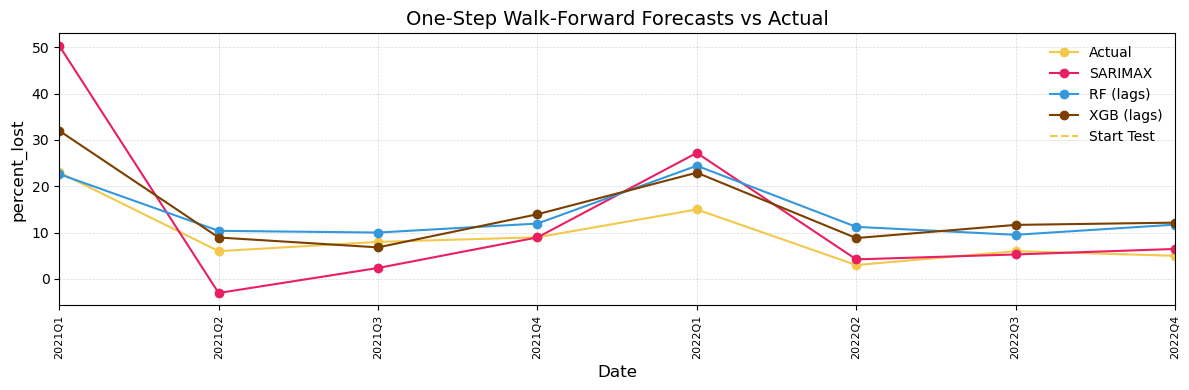

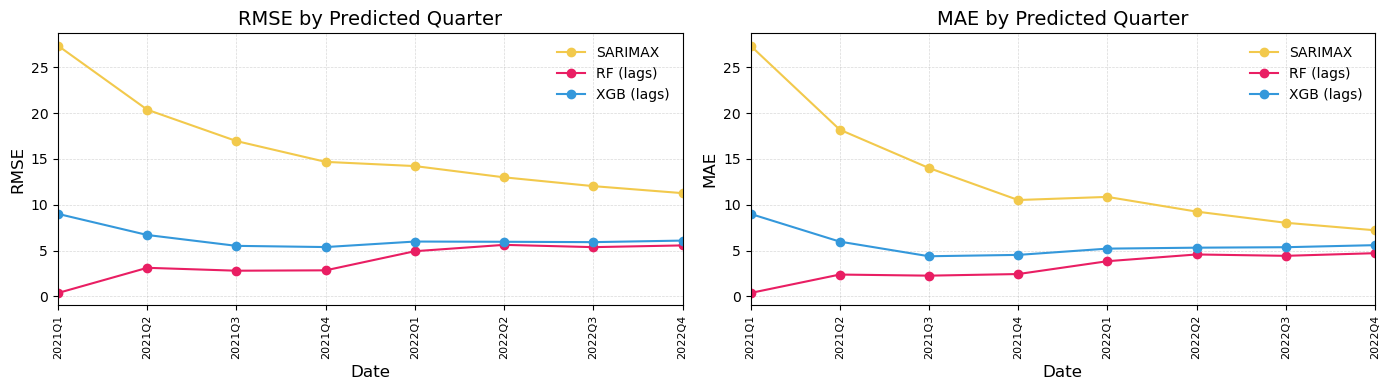

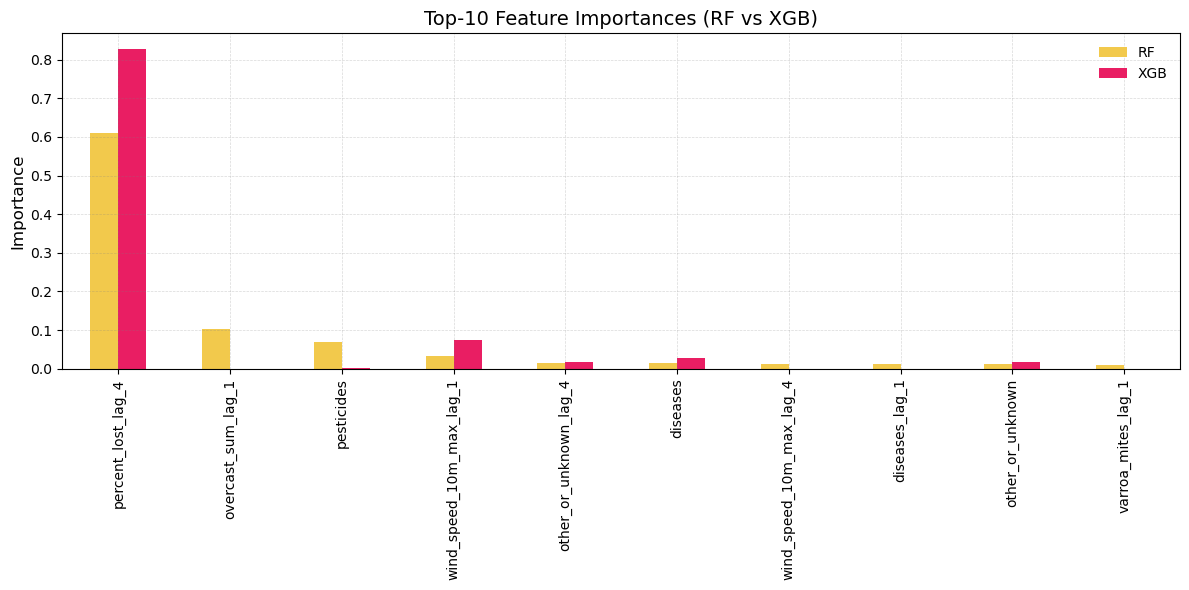

,Model,RMSE,MAE
0,SARIMAX,11.26,7.21
1,RF (lags),5.56,4.71
2,XGB (lags),6.08,5.59


In [71]:
compare_multivariate_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[                                 # adjust features of interest as needed
        'varroa_mites','other_pests_and_parasites','diseases','pesticides','other_or_unknown',
        'overcast_sum','clear_sky_sum','longitude','partly_cloudy_sum','relative_humidity_2m_max',
        'mainly_clear_sum','wind_speed_10m_max','D4_mean'
    ],  
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Multiple states example for a particular prediction
  </h5>
</div>

In [72]:
# available states
bees['state'].unique()

array(['Alabama', 'Iowa', 'Tennessee', 'Indiana', 'Illinois', 'Texas',
       'Idaho', 'Utah', 'Hawaii', 'South Dakota', 'Vermont', 'Florida',
       'Virginia', 'Connecticut', 'Washington', 'Colorado',
       'West Virginia', 'California', 'Wisconsin', 'Georgia', 'Arkansas',
       'Kansas', 'Kentucky', 'Nebraska', 'New Mexico', 'Montana',
       'Missouri', 'New York', 'Mississippi', 'North Carolina',
       'Minnesota', 'South Carolina', 'North Dakota', 'Ohio',
       'Massachusetts', 'Oklahoma', 'Maryland', 'Maine', 'Oregon',
       'Louisiana', 'Pennsylvania', 'Michigan', 'Wyoming', 'New Jersey',
       'Arizona'], dtype=object)

In [73]:
# features for multivariate models
bees.columns

Index(['state', 'latitude', 'longitude', 'quarter', 'temperature_2m_mean',
       'temperature_2m_sum', 'relative_humidity_2m_mean',
       'relative_humidity_2m_sum', 'wind_speed_10m_max', 'temperature_2m_max',
       'relative_humidity_2m_max', 'temperature_2m_min',
       'relative_humidity_2m_min', 'precipitation_hours_sum',
       'moderate_drizzle_sum', 'moderate_rain_sum', 'light_rain_sum',
       'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum', 'clear_sky_sum',
       'light_drizzle_sum', 'mainly_clear_sum', 'heavy_drizzle_sum',
       'light_snow_sum', 'heavy_snow_sum', 'moderate_snow_sum', 'year',
       'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean', 'D4_mean', 'D0_max',
       'D1_max', 'D2_max', 'D3_max', 'D4_max', 'num_colonies', 'max_colonies',
       'lost_colonies', 'percent_lost', 'added_colonies', 'renovated_colonies',
       'percent_renovated', 'varroa_mites', 'other_pests_and_parasites',
       'diseases', 'pesticides', 'other_or_unknown', 'date'],
      dtype='

<div style="
    background-color: #fffad5;
    color: black;
    border-radius: 5px;
    padding: 10px;
">
  <p style="margin: 0; font-weight: bold;">
    Fill in user inputs as needed:
  </p>
  <ul style="margin: 5px 0 0 20px; padding: 0; list-style-type: disc; color: black; font-weight: normal;">
    <li><strong>model_choice</strong>: Model of choice as string</li>
    <li><strong>states</strong>: States of interest as list</li>
    <li><strong>features_to_include</strong>: Features to include in the model as list (not target!)</li>
    <li><strong>n_test</strong>: Number of periods to hold out (e.g. <code>8</code>)</li>
    <li><strong>lags</strong>: List of lag orders to use (e.g. <code>[1, 4]</code>)</li>
    <li><strong>seasonal_m</strong>: Seasonal period (e.g. <code>4</code> for quarterly data)</li>
  </ul>
</div>



=== Results for California ===


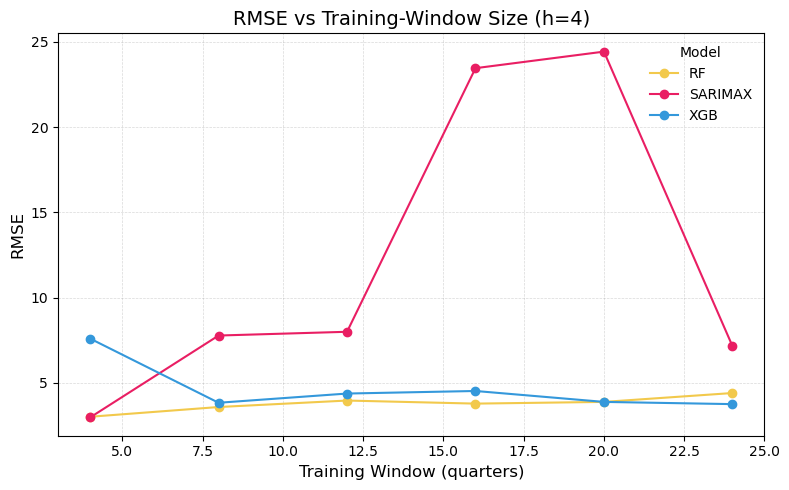

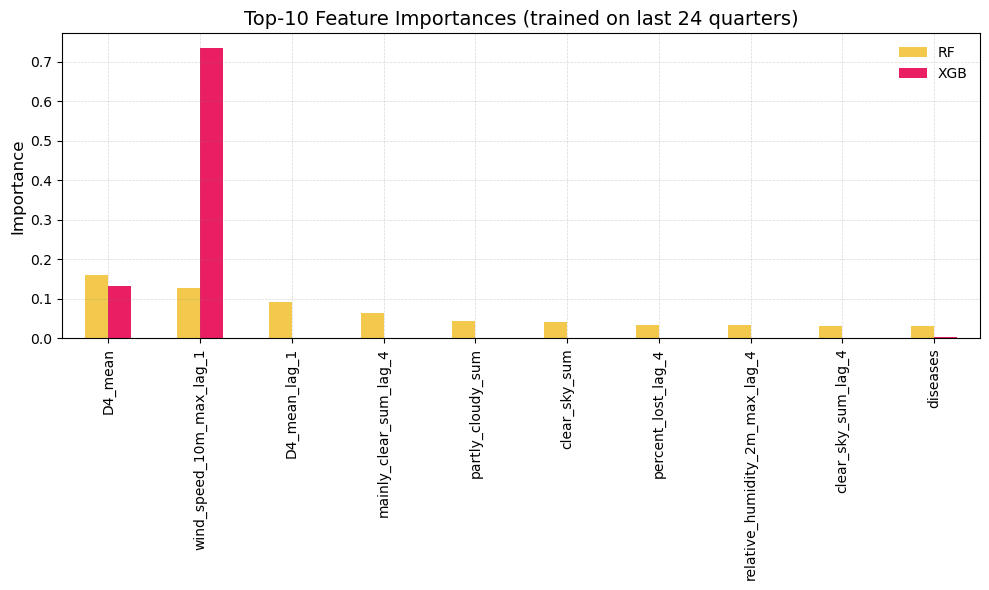

    train_quarters    Model   RMSE    MAE
0                4  SARIMAX   2.98   2.58
1                4       RF   3.02   2.40
2                4      XGB   7.60   6.25
3                8  SARIMAX   7.78   7.37
4                8       RF   3.59   2.70
5                8      XGB   3.84   3.09
6               12  SARIMAX   8.00   7.60
7               12       RF   3.97   3.07
8               12      XGB   4.38   3.47
9               16  SARIMAX  23.45  21.85
10              16       RF   3.79   3.20
11              16      XGB   4.53   3.49
12              20  SARIMAX  24.42  22.67
13              20       RF   3.89   3.08
14              20      XGB   3.89   3.18
15              24  SARIMAX   7.17   6.41
16              24       RF   4.41   3.65
17              24      XGB   3.76   2.95


=== Results for Texas ===


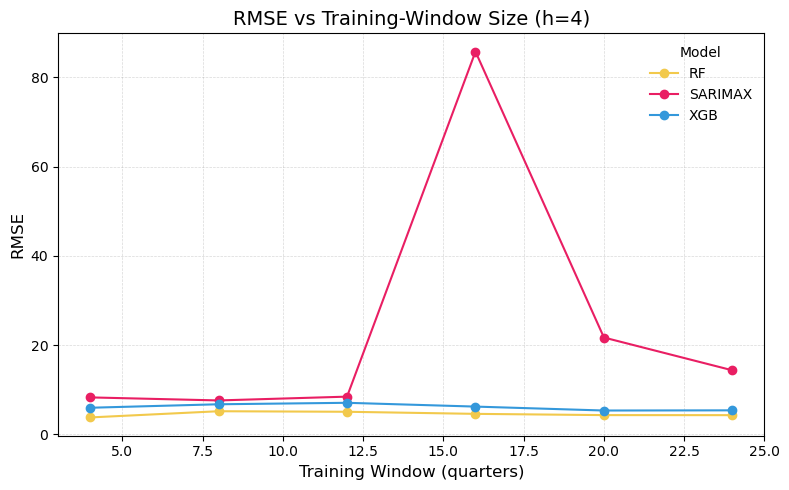

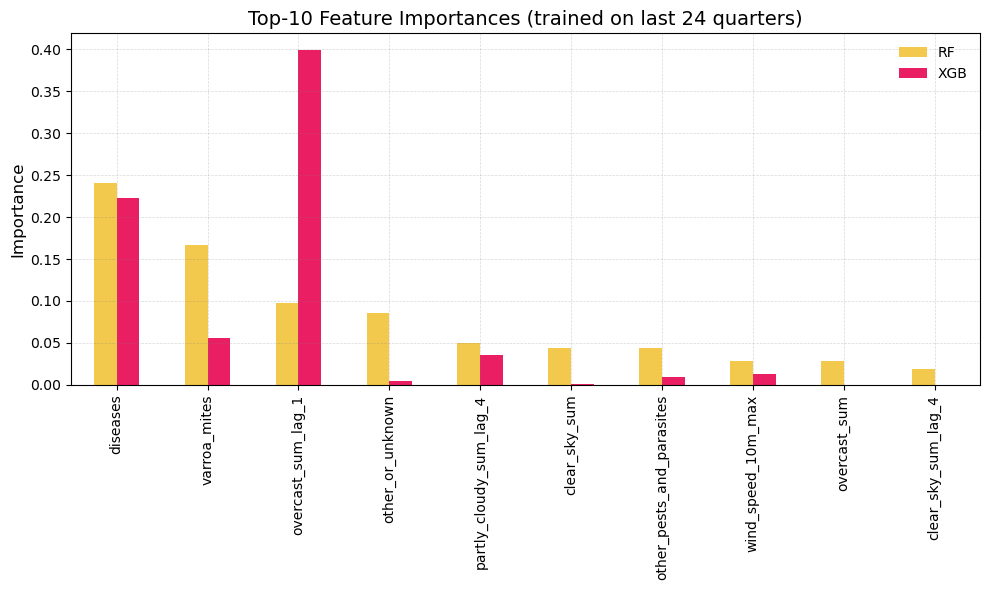

    train_quarters    Model   RMSE    MAE
0                4  SARIMAX   8.26   7.58
1                4       RF   3.77   3.18
2                4      XGB   5.94   5.75
3                8  SARIMAX   7.58   7.47
4                8       RF   5.16   4.02
5                8      XGB   6.72   5.34
6               12  SARIMAX   8.43   7.11
7               12       RF   5.04   4.09
8               12      XGB   7.05   5.74
9               16  SARIMAX  85.76  49.55
10              16       RF   4.57   3.57
11              16      XGB   6.20   5.09
12              20  SARIMAX  21.68  16.39
13              20       RF   4.29   3.51
14              20      XGB   5.32   4.59
15              24  SARIMAX  14.33  11.13
16              24       RF   4.28   3.51
17              24      XGB   5.36   4.19


=== Results for Florida ===


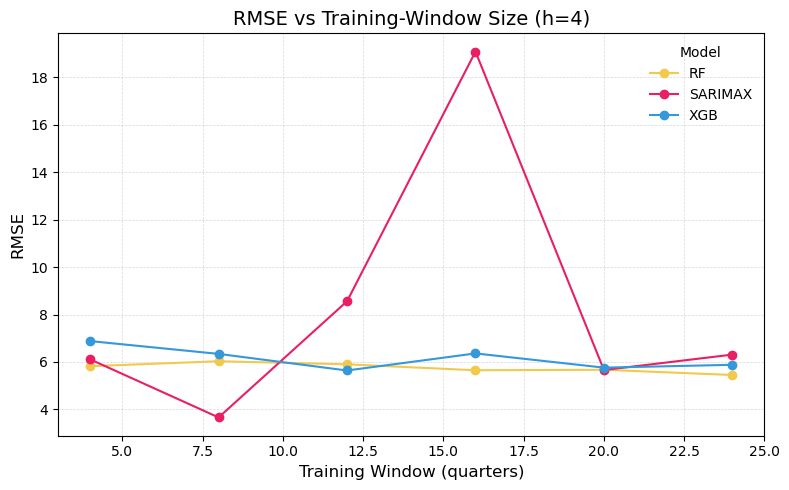

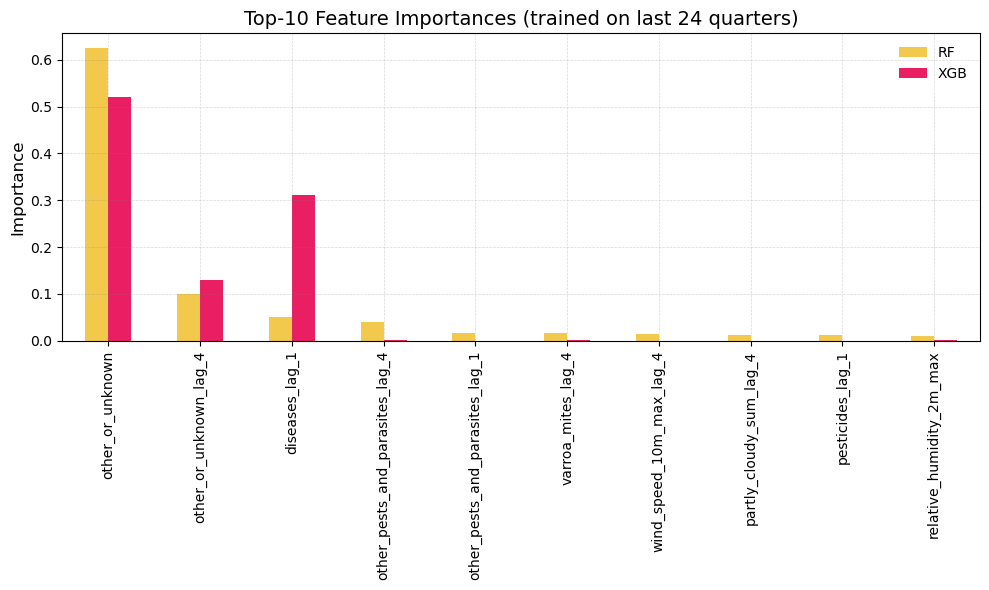

    train_quarters    Model   RMSE    MAE
0                4  SARIMAX   6.11   4.92
1                4       RF   5.82   5.41
2                4      XGB   6.88   6.13
3                8  SARIMAX   3.66   3.19
4                8       RF   6.03   5.57
5                8      XGB   6.34   5.76
6               12  SARIMAX   8.56   7.08
7               12       RF   5.90   5.48
8               12      XGB   5.64   5.18
9               16  SARIMAX  19.09  14.92
10              16       RF   5.65   5.37
11              16      XGB   6.36   5.95
12              20  SARIMAX   5.66   5.18
13              20       RF   5.67   5.31
14              20      XGB   5.76   5.16
15              24  SARIMAX   6.31   5.19
16              24       RF   5.45   5.15
17              24      XGB   5.88   5.60



In [74]:
# Example adjustable loop with model selection

# Choose which model to run:
# Options: 'univariate_static', 'univariate_walk', 
#          'multivariate_static', 'multivariate_windows', 'multivariate_walk'
model_choice = 'multivariate_windows'  

# User inputs
states = ['California', 'Texas', 'Florida'] 
n_test = 8
lags   = [1, 4]
seasonal_m=4
features_to_include = [
    'varroa_mites','other_pests_and_parasites','diseases','pesticides',
    'other_or_unknown','overcast_sum','clear_sky_sum','longitude',
    'partly_cloudy_sum','relative_humidity_2m_max','mainly_clear_sum',
    'wind_speed_10m_max','D4_mean'
]

# Map choice to actual function and its signature
model_map = {
    'univariate_static': compare_univariate_static,
    'univariate_walk':   evaluate_and_plot_walkforward,
    'multivariate_static': compare_multivariate_models,
    'multivariate_windows': compare_multivariate_static_windows,
    'multivariate_walk': compare_multivariate_walkforward
}

for st in states:
    print(f"\n=== Results for {st} ===")
    df_st = bees[bees['state'] == st].copy()
    
    # Check enough data
    min_needed = n_test + max(lags) + 1
    if len(df_st) < min_needed:
        print(f"Skipping {st}: only {len(df_st)} quarters (need ≥ {min_needed})")
        continue
    
    func = model_map.get(model_choice)
    if func is None:
        raise ValueError(f"Unknown model_choice: {model_choice}")

    # Build kwargs depending on selected function
    common_kwargs = {
        'df': df_st,
        'date_col': 'date',
        'target_col': 'percent_lost',
    }
    if model_choice in ['univariate_static', 'multivariate_static']:
        common_kwargs.update({'n_test': n_test, 'lags': lags})
    elif model_choice == 'univariate_walk':
        common_kwargs.update({'n_test': n_test, 'lags': lags})
    elif model_choice == 'multivariate_walk':
        common_kwargs.update({
            'n_test': n_test,
            'lags': lags,
            'exog_cols': features_to_include
        })
    elif model_choice == 'multivariate_windows':
        common_kwargs.update({
            'windows': [4,8,12,16,20,24],
            'forecast_horizon': 4,
            'seasonal_m': 4,
            'lags': lags,
            'exog_cols': features_to_include
        })

    # Run the selected model
    try:
        metrics = func(**common_kwargs)
    except Exception as e:
        print(f"Error for {st}: {e}")
        continue

    # Display metrics
    print(metrics)
    print("\n" + "="*160)

<div
  style="
    background-color: #FCE205;
    padding: 10px 20px;      /* you can tweak horizontal padding */
    border-radius: 5px;
    color: black;
    font-weight: bold;
    height: 60px;            /* adjust as needed */
    line-height: 50px;
  "
>
  <h3 style="margin: 0;">Conclusions</h3>
</div>

1. **Data Limitations**

   * With only 32 quarterly observations per state, model accuracy is limited. Many methods struggle to estimate reliably when there are so few data points.
   * Even the walk-forward framework can only evaluate eight one-step forecasts—small sample sizes yield high variability in RMSE and MAE estimates.

2. **Inter-State Performance Differences**

   * Some states (e.g. California) consistently exhibit lower forecast errors, while others (e.g. Florida) show larger deviations. This reflects both underlying volatility in the percent-lost series and the adequacy of exogenous predictors in each region.
   * States with smoother seasonal patterns benefit more from Holt–Winters and SARIMAX whereas regions with more erratic patterns tend to see better performance from machine-learning methods.

3. **Feature Importance Varies by State**

   * In Random Forest and XGBoost importance rankings, **relative\_humidity**, **pesticide use**, and **varroa\_mites** often top the list—but their exact order and magnitude differ markedly between states.
   * For example, in Texas, wind-speed features might rank higher than pesticide measures, whereas in Ohio the opposite holds.

4. **Top-Performing Models**

   * **SARIMAX** (with quarterly seasonality) generally delivers a robust baseline—especially in states with clear seasonal cycles.
   * **Machine-learning on lagged features** (RF or XGB) can outperform when non-linear interactions between past loss rates and exogenous covariates matter most.
   * **Holt–Winters** tends to underperform relative to SARIMAX when exogenous drivers are strong, but remains the simplest benchmark.

5. **Recommendations & Next Steps**

   * **Hyperparameter Tuning per State**
     ­ Fine-tune SARIMAX orders (p,d,q) and seasonal terms via grid or Bayesian search. Likewise, optimize RF/XGB tree depth, learning rate, and regularization for each state’s unique data.
   * **Feature Engineering**
     ­ Incorporate additional lags, rolling statistics (e.g. 4-quarter moving averages), or interaction terms between stressors (e.g. humidity × pesticide).
   * **Ensemble Methods**
     ­ Blend forecasts from SARIMAX and machine-learning to capture both linear seasonality and non-linear exogenous effects.
   * **Longer Horizons & More Data**
     ­ Seek to extend the dataset (e.g. monthly rather than quarterly) or integrate external economic/agricultural indicators to boost sample size and predictor richness.

By acknowledging data scarcity and tailoring models to each state’s characteristics, forecast accuracy can be improved.
